In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:

from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    # [[-1,1]] [[-1],[1]] can calculate the dx,dy with surrownding values
    
    dx = ndimage.correlate(image, [[1,-1]],mode = 'nearest')
    dy = ndimage.correlate(image, [[1],[-1]],mode = 'nearest')
    mag = np.sqrt(dx*dx+dy*dy);
    epsilon = 1e-5
    dx = np.where(dx == 0,epsilon,dx)
    ori = np.arctan(np.divide(dy,dx))

    
    return mag,ori

In [4]:
#we will only use:  ski.util.view_as_windows for computing hog descriptor
import skimage as ski 
import math
def hog(image,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
        
    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram
        
    """   
    
    # determine the size of the HOG descriptor
    (h,w) = image.shape
    h2 = int(np.ceil(h/float(bsize)))
    w2 = int(np.ceil(w/float(bsize)))
    ohist = np.zeros((h2,w2,norient))
    
    # pad the input image on right and bottom as needed so that it 
    # is a multiple of bsize
    
    
    #quotation is w/bsize
    q1 = w//bsize
    pw=(0,0)
    
    #get the quotation and find how many padding witdth  needed
    if q1*bsize<w:
        pw = bsize-(w-q1*bsize)
        pw= (0,pw)
        
    elif q1*bsize>w:
        pw = bsize-(q1*bsize-w)
        pw= (0,pw)
    
    
    #quotation2 is h/bsize
    ph=(0,0)
    
    #get the quotation and find how many padding height needed
    q2 = h//bsize
    if q2*bsize<h:
        ph = bsize-(h-q2*bsize)
        ph= (0,ph)
    elif q2*bsize>h:
        ph = bsize-(q2*bsize-h)
        ph= (0,ph)
    
    
    
    image = np.pad(image,(ph,pw),'edge')
    
    # make sure we did the padding correctly
    assert(image.shape==(h2*bsize,w2*bsize))
    
    # compute image gradients
    (mag,ori) = mygradient(image)
    
    # choose a threshold which is 10% of the maximum gradient magnitude in the image
    thresh = 0.1 * np.max(mag)
    
    
    # separate out pixels into orientation channels, dividing the range of orientations
    # [-pi/2,pi/2] into norient equal sized bins and count how many fall in each block    
    binEdges = np.linspace(-np.pi/2, np.pi/2, norient+1)
    
    # as a sanity check, make sure every pixel gets assigned to at most 1 bin.
    bincount = np.zeros((h2*bsize,w2*bsize))
    
    
    for i in range(norient):
    
        B1 = np.zeros(image.shape)
        #binEdges[i] shows the range limit, if larger that thresh set to 1 else 0
        
        
        B1 = (mag>thresh)* (ori > binEdges[i]) * (ori <= binEdges[i+1])
        
        
                
        #sanity check: record which pixels have been selected at this orientation
        bincount = bincount + B1
        
        
        
        #pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B1,(bsize,bsize),step=bsize)
        
        
        
        #sum up the count for each block and store the results
        
        #to sum up values in last two dimensions
        sum1 = np.zeros((h2,w2))
        
        sum1[:][:]= np.sum(chblock,axis=(2,3))
        
        ohist[:,:,i] = sum1
        
    #each pixel should have only selected at most once
    assert(np.all(bincount<=1)) 
    
    # lastly, normalize the histogram so that the sum along the orientation dimension is 1
    # note: don't divide by 0! If there are no edges in a block (i.e. the sum of counts
    # is 0) then your code should leave all the values as zero. 

    s2= np.sum(ohist,axis=2)
    
    #get sum of counts and use if to eliminate when 0

    for i in range(norient):
        for j in range(s2.shape[0]):
            for k in range(s2.shape[1]): 
                if s2[j][k] == 0:
                    ohist[j,k,i] = 0
                else:
                    ohist[j,k,i] = ohist[j,k,i]/(s2[j][k])
    
    
    assert(ohist.shape==(h2,w2,norient))
    
    return ohist

In [6]:
#we will only use:  scipy.ndimage.correlate
from scipy import ndimage

def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """   
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)
    
    
    #cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1]))
    
    for i in range(norient):
        resp = resp + ndimage.correlate(fmap[:,:,i], template[:,:,i])
    
    
    
    #sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
                    

    
    val = np.sort(resp.flatten())[::-1] 
    ind = np.argsort(resp.flatten())[::-1]  
    
    #work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []
    while ((detcount < ndetect) and (i < len(val))):
        # convert 1d index into 2d index
        
        
        yb = ind[i]//resp.shape[1]
        xb = ind[i]%resp.shape[1]

        
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        #covert block index to pixel coordinates based on bsize
        xp = bsize * xb
        yp = bsize * yb 
        
        #check if this detection overlaps any detections that we've already added
        #to the list. compare the x,y coordinates of this detection to the x,y 
        # coordinates of the detections already in the list and see if any overlap
        # by checking if the distance between them is less than 70% of the template
        # width/height
        
        overlap = 0
        height1 = template.shape[0]
        width1 = template.shape[1]
        for d in detections:
            
            #compare to previous x, the distance caculate as sqrt of delta x^2 + delta y^2
            previousx = d[0]
            previousy = d[1]
            d1 = (previousx - xp)* (previousx - xp) + (previousy - yp)*(previousy - yp) 
            if np.sqrt(d1) < 0.7 * height1 * bsize:
                overlap = 1
            elif np.sqrt(d1) < 0.7 * width1 * bsize: 
                overlap = 1
                
                
        #if the detection doesn't overlap then add it to the list
        if overlap!=1:
            detcount = detcount + 1
            detections.append((xp,yp,val[i]))
        
        i=i+1
    
    if (len(detections) < ndetect):
        print('WARNING: unable to find ',ndetect,' non-overlapping detections')
        
    return detections

In [7]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        
    plt.show()

In [9]:

from skimage import transform,data
def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    
    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    
    """           
    
    #compute the template size in pixels 
    #corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    #figure to show positive training examples
    fig1 = plt.figure()
    pltct = 1

    #accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in posfiles:
        #load in a cropped positive example
        img = plt.imread(file)
        if (img.dtype == np.uint8): 
            img = img.astype(float) / 256
        img = img.mean(axis=2)
        
        
        #convert to grayscale and resize to fixed dimension tsize_pix
        #using skimage.transform.resize if needed.
        img = ski.transform.resize(img, tsize_pix)
        
        #display the example. if you want to train with a large # of examples, 
        #you may want to modify this, e.g. to show only the first 5.
        ax = fig1.add_subplot(len(posfiles),1,pltct)
        ax.imshow(img,cmap=plt.cm.gray)
        pltct = pltct + 1
        
        #extract feature
        fmap = hog(img)
        
        #compute running average
        pos_t = fmap+pos_t

    sizeposfile=len(posfiles) 
    pos_t = pos_t/sizeposfile
    #fig1.show()
    
    
    # repeat same process for negative examples
    fig2 = plt.figure()
    pltct = 1  
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        img = plt.imread(file)
        if (img.dtype == np.uint8): 
            img = img.astype(float) / 256
        img = img.mean(axis=2)
        
        img = ski.transform.resize(img, tsize_pix)
        ax = fig2.add_subplot(len(negfiles),1,pltct)
        ax.imshow(img,cmap=plt.cm.gray)
        pltct = pltct + 1
        fmap = hog(img)
        neg_t  = fmap+neg_t
        
    sizenegsfile=len(negfiles) 
    neg_t = neg_t/sizenegsfile
    
    # add code here to visualize the positive and negative parts of the template
    # using hogvis. you should separately visualize pos_t and neg_t rather than
    # the final tempalte.
    plt.show()
    pos1 = hogvis(pos_t)
    neg1 = hogvis(neg_t)
    plt.imshow(pos1)
    plt.show()
    plt.imshow(neg1)
    plt.show()

    # now construct our template as the average positive minus average negative
    template = pos_t - neg_t

    
    return template 


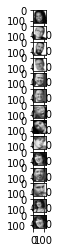

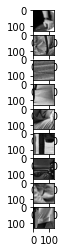

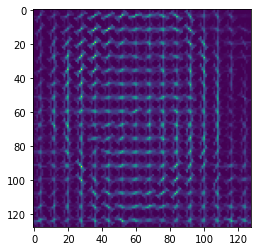

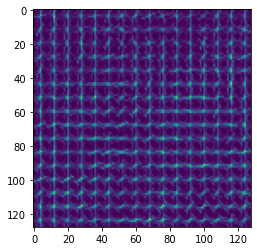

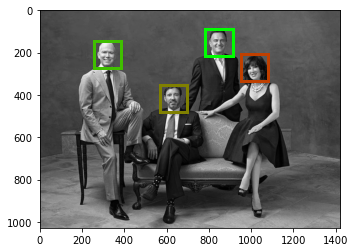

In [10]:
# assume template is 16x16 blocks, you may want to adjust this 
# for objects of different size or aspect ratio.
# compute image a template size
bsize=8
tsize=np.array([16,16])  
tsize_pix = bsize*tsize 
posfiles = ('pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg',
            'pos6.jpg','pos8.jpg','pos9.jpg','pos10.jpg','pos12.jpg','pos7.jpg','pos11.jpg','pos14.jpg','pos13.jpg')



negfiles = ('neg3.jpg','neg2.jpg','neg8.jpg','neg5.jpg','neg10.jpg','neg11.jpg','neg12.jpg','neg13.jpg','neg6.jpg')


template= learn_template(posfiles,negfiles)

img = plt.imread("faces3.jpg")
img = img.astype(float) / 256
img = img.mean(axis=2)
plt.imshow(img)

detections = detect(img,template,4)
plot_detections(img,detections,tsize_pix)


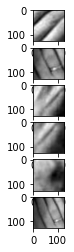

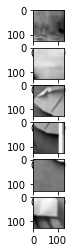

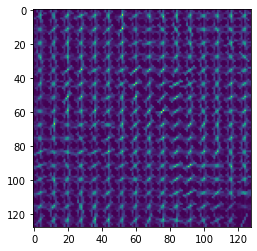

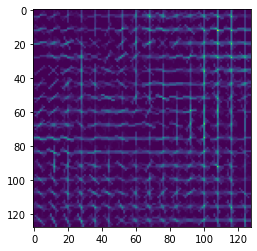

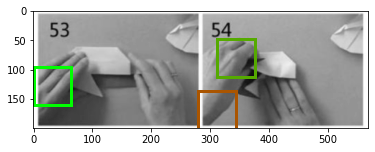

In [11]:
bsize=8
tsize=np.array([8,8])  
tsize_pix = bsize*tsize
posfiles = ('hands/pos1.jpg','hands/pos2.jpg','hands/pos3.jpg','hands/pos4.jpg','hands/pos5.jpg','hands/pos6.jpg',)

negfiles = ('hands/neg1.jpg','hands/neg3.jpg','hands/neg2.jpg','hands/neg4.jpg','hands/neg5.jpg','hands/neg7.jpg')


template= learn_template(posfiles,negfiles)

img = plt.imread("hands/hands.png")


img = img.astype(float) / 256
img = img.mean(axis=2)

plt.imshow(img)
detections = detect(img,template,3)
plot_detections(img,detections,tsize_pix)
plt.show()